# TNT-LLM: 대규모 텍스트 마이닝

[TNT-LLM](https://arxiv.org/abs/2403.12173)은 Wan 등이 Microsoft의 Bing Copilot 애플리케이션을 위해 개발한 분류 체계 생성 및 분류 시스템을 설명합니다.

원시 대화 로그에서 사용자 의도(또는 기타 카테고리)에 대한 풍부하고 해석 가능한 분류 체계를 생성합니다. 이 분류 체계는 LLM이 로그에 레이블을 지정하는 데 다운스트림에서 사용될 수 있으며, 이는 애플리케이션에 배포할 수 있는 저비용 분류기(예: 임베딩에 대한 로지스틱 회귀 분류기)를 적응시키는 학습 데이터로 사용될 수 있습니다.

TNT-LLM은 세 가지 주요 단계를 가지고 있습니다:

1. 분류 체계 생성
2. 학습 데이터 레이블 지정
3. 분류기 미세 조정 + 배포

이 노트북에서 LangGraph를 적용할 때, 우리는 첫 번째 단계인 분류 체계 생성(아래 다이어그램에서 파란색)에 초점을 맞출 것입니다. 그런 다음 아래의 후속 단계에서 분류기를 레이블 지정하고 적합시키는 방법을 보여줍니다.

<img src="./img/tnt_llm.png" src="../img/tnt_llm.png">

분류 체계를 생성하기 위해 TNT-LLM은 5단계를 제안합니다:

1. **요약** 저비용 LLM을 사용하여 채팅 로그 요약(샘플의 모든 로그에 대해 일괄 처리)
2. **배치** 로그를 무작위 미니배치로 분할
3. **생성** 첫 번째 미니배치에서 초기 분류 체계 생성
4. **업데이트** 비평 및 수정 프롬프트를 통해 후속 미니배치마다 분류 체계 업데이트
5. **검토** 최종 샘플을 사용하여 품질을 평가하고 최종 값을 생성하여 최종 분류 체계 검토

## 설정

먼저 필요한 패키지를 설치하고 API 키를 설정하겠습니다


In [ ]:
%%capture --no-stderr
%pip install -U langgraph langchain_anthropic langsmith langchain-community
%pip install -U sklearn langchain_openai

In [ ]:
import getpass
import os


def _set_env(var: str):
    if os.environ.get(var):
        return
    os.environ[var] = getpass.getpass(var + ":")


_set_env("ANTHROPIC_API_KEY")

<div class="admonition tip">
    <p class="admonition-title"><a href="https://smith.langchain.com">LangSmith</a>를 LangGraph 개발에 설정하세요</p>
    <p style="padding-top: 5px;">
        LangSmith에 가입하여 LangGraph 프로젝트의 문제를 빠르게 발견하고 성능을 개선하세요. LangSmith를 사용하면 추적 데이터를 사용하여 LangGraph로 구축된 LLM 앱을 디버그, 테스트 및 모니터링할 수 있습니다 — 시작 방법에 대한 자세한 내용은 <a href="https://docs.smith.langchain.com">여기</a>에서 확인하세요. 
    </p>
</div>

## 그래프 정의

### 그래프 상태

StateGraph의 각 노드는 상태를 받아들이고 (업데이트된 상태를 반환하므로), 처음에 이를 정의하겠습니다.

우리의 플로우는 문서 목록을 받아들이고, 이를 배치로 나눈 다음, 해석 가능한 "클러스터"로 후보 분류 체계를 생성하고 개선합니다.


In [12]:
import logging
import operator
from typing import Annotated, List, Optional
from typing_extensions import TypedDict

logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger("tnt-llm")


class Doc(TypedDict):
    id: str
    content: str
    summary: Optional[str]
    explanation: Optional[str]
    category: Optional[str]


class TaxonomyGenerationState(TypedDict):
    # 원시 문서; 첫 번째 단계에서 그 안에 요약을 주입합니다
    documents: List[Doc]
    # 간결하게 하기 위한 인덱스
    minibatches: List[List[int]]
    # 후보 분류 체계 (전체 궤적)
    clusters: Annotated[List[List[dict]], operator.add]

### 노드 정의

#### 1. 문서 요약

채팅 로그는 꽤 길어질 수 있습니다. 우리의 분류 체계 생성 단계는 카테고리의 분포를 적절히 포착하기 위해 크고 다양한 미니배치를 볼 필요가 있습니다. 모든 것이 컨텍스트 창에 효율적으로 맞도록 하기 위해 먼저 각 채팅 로그를 요약합니다. 다운스트림 단계는 원시 문서 내용 대신 이러한 요약을 사용합니다.


In [3]:
import re

from langchain import hub
from langchain_anthropic import ChatAnthropic
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableConfig, RunnableLambda, RunnablePassthrough

summary_prompt = hub.pull("wfh/tnt-llm-summary-generation").partial(
    summary_length=20, explanation_length=30
)


def parse_summary(xml_string: str) -> dict:
    summary_pattern = r"<summary>(.*?)</summary>"
    explanation_pattern = r"<explanation>(.*?)</explanation>"

    summary_match = re.search(summary_pattern, xml_string, re.DOTALL)
    explanation_match = re.search(explanation_pattern, xml_string, re.DOTALL)

    summary = summary_match.group(1).strip() if summary_match else ""
    explanation = explanation_match.group(1).strip() if explanation_match else ""

    return {"summary": summary, "explanation": explanation}


summary_llm_chain = (
    summary_prompt | ChatAnthropic(model="claude-3-haiku-20240307") | StrOutputParser()
    # 더 쉬운 구성을 위해 추적 이름을 사용자 지정합니다
).with_config(run_name="GenerateSummary")
summary_chain = summary_llm_chain | parse_summary


# 이제 map-reduce 체인에서 "map" 연산으로 결합합니다
# 입력: 상태
# 출력: 상태 U 요약
# 문서를 병렬로 처리합니다
def get_content(state: TaxonomyGenerationState):
    docs = state["documents"]
    return [{"content": doc["content"]} for doc in docs]


map_step = RunnablePassthrough.assign(
    summaries=get_content
    # 이것은 효과적으로 "map" 연산을 생성합니다
    # 개별 오류를 처리하여 이를 더 강력하게 만들 수 있습니다
    | RunnableLambda(func=summary_chain.batch, afunc=summary_chain.abatch)
)


def reduce_summaries(combined: dict) -> TaxonomyGenerationState:
    summaries = combined["summaries"]
    documents = combined["documents"]
    return {
        "documents": [
            {
                "id": doc["id"],
                "content": doc["content"],
                "summary": summ_info["summary"],
                "explanation": summ_info["explanation"],
            }
            for doc, summ_info in zip(documents, summaries)
        ]
    }


# 이것이 실제로 노드 자체입니다!
map_reduce_chain = map_step | reduce_summaries

#### 2. 미니배치로 분할

각 미니배치에는 문서의 무작위 샘플이 포함됩니다. 이를 통해 플로우는 새로운 데이터를 사용하여 현재 분류 체계의 불충분한 점을 식별할 수 있습니다.


In [4]:
import random


def get_minibatches(state: TaxonomyGenerationState, config: RunnableConfig):
    batch_size = config["configurable"].get("batch_size", 200)
    original = state["documents"]
    indices = list(range(len(original)))
    random.shuffle(indices)
    if len(indices) < batch_size:
        # 단일 배치를 채울 수 없는 경우 불필요하게 패딩하지 마십시오
        return [indices]

    num_full_batches = len(indices) // batch_size

    batches = [
        indices[i * batch_size : (i + 1) * batch_size] for i in range(num_full_batches)
    ]

    leftovers = len(indices) % batch_size
    if leftovers:
        last_batch = indices[num_full_batches * batch_size :]
        elements_to_add = batch_size - leftovers
        last_batch += random.sample(indices, elements_to_add)
        batches.append(last_batch)

    return {
        "minibatches": batches,
    }

#### 3.a 분류 체계 생성 유틸리티

그래프의 이 섹션은 생성 -> 업데이트 🔄 -> 검토 주기입니다. 각 노드는 많은 로직을 공유하며, 이를 아래의 공유 함수로 분리했습니다.


In [5]:
from typing import Dict

from langchain_core.runnables import Runnable


def parse_taxa(output_text: str) -> Dict:
    """생성된 출력에서 분류 체계를 추출합니다."""
    cluster_matches = re.findall(
        r"\s*<id>(.*?)</id>\s*<name>(.*?)</name>\s*<description>(.*?)</description>\s*",
        output_text,
        re.DOTALL,
    )
    clusters = [
        {"id": id.strip(), "name": name.strip(), "description": description.strip()}
        for id, name, description in cluster_matches
    ]
    # 다운스트림에서 사용되지 않으므로 설명을 구문 분석하지 않습니다
    return {"clusters": clusters}


def format_docs(docs: List[Doc]) -> str:
    xml_table = "<conversations>\n"
    for doc in docs:
        xml_table += f"<conv_summ id={doc['id']}>{doc['summary']}</conv_summ>\n"
    xml_table += "</conversations>"
    return xml_table


def format_taxonomy(clusters):
    xml = "<cluster_table>\n"
    for label in clusters:
        xml += "  <cluster>\n"
        xml += f"    <id>{label['id']}</id>\n"
        xml += f"    <name>{label['name']}</name>\n"
        xml += f"    <description>{label['description']}</description>\n"
        xml += "  </cluster>\n"
    xml += "</cluster_table>"
    return xml


def invoke_taxonomy_chain(
    chain: Runnable,
    state: TaxonomyGenerationState,
    config: RunnableConfig,
    mb_indices: List[int],
) -> TaxonomyGenerationState:
    configurable = config["configurable"]
    docs = state["documents"]
    minibatch = [docs[idx] for idx in mb_indices]
    data_table_xml = format_docs(minibatch)

    previous_taxonomy = state["clusters"][-1] if state["clusters"] else []
    cluster_table_xml = format_taxonomy(previous_taxonomy)

    updated_taxonomy = chain.invoke(
        {
            "data_xml": data_table_xml,
            "use_case": configurable["use_case"],
            "cluster_table_xml": cluster_table_xml,
            "suggestion_length": configurable.get("suggestion_length", 30),
            "cluster_name_length": configurable.get("cluster_name_length", 10),
            "cluster_description_length": configurable.get(
                "cluster_description_length", 30
            ),
            "explanation_length": configurable.get("explanation_length", 20),
            "max_num_clusters": configurable.get("max_num_clusters", 25),
        }
    )

    return {
        "clusters": [updated_taxonomy["clusters"]],
    }

#### 3. 초기 분류 체계 생성


In [6]:
# generate -> update -> review 주기의 각 단계에 대해 LLM을 공유합니다
# 이를 위해 Opus 또는 다른 더 강력한 모델 사용을 고려할 수 있습니다
taxonomy_generation_llm = ChatAnthropic(
    model="claude-3-haiku-20240307", max_tokens_to_sample=2000
)


## 초기 생성
taxonomy_generation_prompt = hub.pull("wfh/tnt-llm-taxonomy-generation").partial(
    use_case="Generate the taxonomy that can be used to label the user intent in the conversation.",
)

taxa_gen_llm_chain = (
    taxonomy_generation_prompt | taxonomy_generation_llm | StrOutputParser()
).with_config(run_name="GenerateTaxonomy")


generate_taxonomy_chain = taxa_gen_llm_chain | parse_taxa


def generate_taxonomy(
    state: TaxonomyGenerationState, config: RunnableConfig
) -> TaxonomyGenerationState:
    return invoke_taxonomy_chain(
        generate_taxonomy_chain, state, config, state["minibatches"][0]
    )

#### 4. 분류 체계 업데이트

이것은 N번 반복되는 "비평 -> 수정" 단계입니다.


In [7]:
taxonomy_update_prompt = hub.pull("wfh/tnt-llm-taxonomy-update")

taxa_update_llm_chain = (
    taxonomy_update_prompt | taxonomy_generation_llm | StrOutputParser()
).with_config(run_name="UpdateTaxonomy")


update_taxonomy_chain = taxa_update_llm_chain | parse_taxa


def update_taxonomy(
    state: TaxonomyGenerationState, config: RunnableConfig
) -> TaxonomyGenerationState:
    which_mb = len(state["clusters"]) % len(state["minibatches"])
    return invoke_taxonomy_chain(
        update_taxonomy_chain, state, config, state["minibatches"][which_mb]
    )

#### 5. 분류 체계 검토

이것은 모든 미니배치를 처리한 후에 실행됩니다.


In [8]:
taxonomy_review_prompt = hub.pull("wfh/tnt-llm-taxonomy-review")

taxa_review_llm_chain = (
    taxonomy_review_prompt | taxonomy_generation_llm | StrOutputParser()
).with_config(run_name="ReviewTaxonomy")


review_taxonomy_chain = taxa_review_llm_chain | parse_taxa


def review_taxonomy(
    state: TaxonomyGenerationState, config: RunnableConfig
) -> TaxonomyGenerationState:
    batch_size = config["configurable"].get("batch_size", 200)
    original = state["documents"]
    indices = list(range(len(original)))
    random.shuffle(indices)
    return invoke_taxonomy_chain(
        review_taxonomy_chain, state, config, indices[:batch_size]
    )

### 그래프 컴파일

모든 기능이 정의되었으므로 그래프를 빌드할 수 있습니다!


In [13]:
from langgraph.graph import StateGraph, START, END

graph = StateGraph(TaxonomyGenerationState)
graph.add_node("summarize", map_reduce_chain)
graph.add_node("get_minibatches", get_minibatches)
graph.add_node("generate_taxonomy", generate_taxonomy)
graph.add_node("update_taxonomy", update_taxonomy)
graph.add_node("review_taxonomy", review_taxonomy)

graph.add_edge("summarize", "get_minibatches")
graph.add_edge("get_minibatches", "generate_taxonomy")
graph.add_edge("generate_taxonomy", "update_taxonomy")


def should_review(state: TaxonomyGenerationState) -> str:
    num_minibatches = len(state["minibatches"])
    num_revisions = len(state["clusters"])
    if num_revisions < num_minibatches:
        return "update_taxonomy"
    return "review_taxonomy"


graph.add_conditional_edges(
    "update_taxonomy",
    should_review,
    # 선택 사항 (하지만 아래 다이어그램이 올바르게 그려지려면 필요함)
    {"update_taxonomy": "update_taxonomy", "review_taxonomy": "review_taxonomy"},
)
graph.add_edge("review_taxonomy", END)

graph.add_edge(START, "summarize")
app = graph.compile()

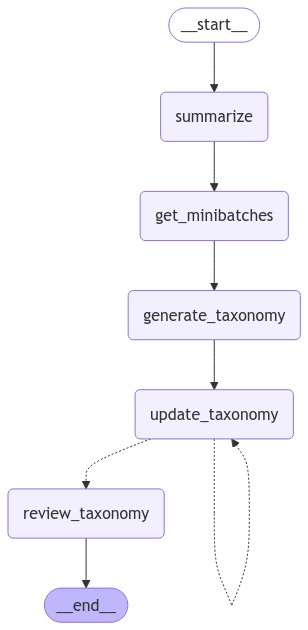

In [14]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # 이것은 몇 가지 추가 종속성이 필요하며 선택 사항입니다
    pass

## 그래프 사용

문서에는 **어떤** 내용이든 포함될 수 있지만, [LangSmith](https://smith.langchain.com)에서 캡처한 것과 같은 챗봇 로그에서 정말 잘 작동한다는 것을 발견했습니다.

아래에서 이를 예제로 사용하겠습니다. `project_name`을 자신의 LangSmith 프로젝트로 업데이트하세요.

아래의 `run_to_doc` 함수를 사용자 정의해야 할 가능성이 높습니다. 예상 키가 이 노트북 작성자의 키와 다를 수 있기 때문입니다.


In [193]:
from datetime import datetime, timedelta

from langsmith import Client

project_name = "YOUR PROJECT NAME"  # 자신의 프로젝트로 업데이트하세요
client = Client()

past_week = datetime.now() - timedelta(days=7)
runs = list(
    client.list_runs(
        project_name=project_name,
        filter="eq(is_root, true)",
        start_time=past_week,
        # 입력 + 출력만 반환하면 됩니다
        select=["inputs", "outputs"],
    )
)


# langsmith 추적을 그래프의 Doc 객체로 변환합니다.
def run_to_doc(run) -> Doc:
    turns = []
    idx = 0
    for turn in run.inputs.get("chat_history") or []:
        key, value = next(iter(turn.items()))
        turns.append(f"<{key} idx={idx}>\n{value}\n</{key}>")
        idx += 1
    turns.append(
        f"""
<human idx={idx}>
{run.inputs["question"]}
</human>"""
    )
    if run.outputs and run.outputs["output"]:
        turns.append(
            f"""<ai idx={idx + 1}>
{run.outputs["output"]}
</ai>"""
        )
    return {
        "id": str(run.id),
        "content": ("\n".join(turns)),
    }

#### 호출

이제 실행을 문서로 변환하고 그래프 플로우를 시작합니다. 이것은 시간이 좀 걸립니다! 요약 단계가 가장 오래 걸립니다. 속도를 높이고 싶다면 모델 제공업체 간에 부하를 분산시킬 수 있습니다.


In [21]:
from langchain_community.cache import InMemoryCache
from langchain.globals import set_llm_cache

# 선택 사항. 오류 또는 속도 제한이 발생하고 반복 계산을 피하려는 경우,
# 디버깅하는 동안 이를 설정할 수 있습니다

set_llm_cache(InMemoryCache())

In [ ]:
# 속도를 높이기 위해 1K 문서로 무작위 샘플링합니다
docs = [run_to_doc(run) for run in runs if run.inputs]
docs = random.sample(docs, min(len(docs), 1000))
use_case = (
    "Generate the taxonomy that can be used both to label the user intent"
    " as well as to identify any required documentation (references, how-tos, etc.)"
    " that would benefit the user."
)

stream = app.stream(
    {"documents": docs},
    {
        "configurable": {
            "use_case": use_case,
            # 선택 사항:
            "batch_size": 400,
            "suggestion_length": 30,
            "cluster_name_length": 10,
            "cluster_description_length": 30,
            "explanation_length": 20,
            "max_num_clusters": 25,
        },
        # 문서를 일괄 요약합니다. 오류를 피하기 위해 다음을 제한합니다
        # 허용할 병렬 처리 정도.
        "max_concurrency": 2,
    },
)

for step in stream:
    node, state = next(iter(step.items()))
    print(node, str(state)[:20] + " ...")

## 최종 결과

아래에서 최종 결과를 마크다운으로 렌더링합니다:


In [202]:
from IPython.display import Markdown


def format_taxonomy_md(clusters):
    md = "## Final Taxonomy\n\n"
    md += "| ID | Name | Description |\n"
    md += "|----|------|-------------|\n"

    # 클러스터 데이터로 테이블을 채웁니다
    for label in clusters:
        id = label["id"]
        name = label["name"].replace(
            "|", "\\|"
        )  # 내용 내의 파이프 문자를 이스케이프합니다
        description = label["description"].replace(
            "|", "\\|"
        )  # 파이프 문자를 이스케이프합니다
        md += f"| {id} | {name} | {description} |\n"

    return md


Markdown(format_taxonomy_md(step["__end__"]["clusters"][-1]))

## Final Taxonomy

| ID | Name | Description |
|----|------|-------------|
| 1 | Troubleshooting Network Connectivity Issues | Resolving problems with DNS, network connections, and GitHub extension activation. |
| 2 | Extracting and Analyzing Data | Retrieving and processing data from various sources like text files, databases, and APIs. |
| 3 | Providing Healthcare Insights | Generating medical diagnosis, symptom checking, drug information, and skin condition analysis. |
| 4 | Configuring and Optimizing Models | Adjusting model parameters and hyperparameters to improve performance for a given task. |
| 5 | Generating Creative Poetry | Creating poems using language models and AI-powered tools. |
| 6 | Interacting with Databases | Querying databases, extracting data, and managing errors during data processing. |
| 7 | Querying Vector Databases | Interacting with vector databases like Milvus to store and retrieve high-dimensional data. |
| 8 | Generating Synthetic Data | Creating synthetic data using language models and machine learning techniques. |
| 9 | Integrating Tools and Workflows | Incorporating various tools and libraries into a cohesive workflow for different tasks. |
| 10 | Improving Information Retrieval | Storing and querying multiple vectors per document for better semantic understanding. |
| 11 | Processing Documents and Extracting Text | Parsing and extracting text from various document formats like PDF, DOCX, and HTML. |
| 12 | Building Local Knowledge Bases | Creating knowledge bases from text files, handling text splitting, embeddings, and storage. |
| 13 | Optimizing Conversational Retrieval | Troubleshooting and improving the performance of the ConversationalRetrievalChain in LangChain. |
| 14 | Connecting Databases and Using Agents | Connecting to databases, using agents, and understanding the differences between agent types. |
| 15 | Introspecting LangChain Tools | Accessing and retrieving details about the functions and source code of LangChain tools. |
| 16 | Generating Styled Answers with Retrieval Augmentation | Creating a QA system that generates well-cited answers in a specific style. |
| 17 | Using ZERO_SHOT_REACT_DESCRIPTION Agents | Applying the ZERO_SHOT_REACT_DESCRIPTION agent type in LangChain for chat models. |
| 18 | Automating Microlearning Course Creation | Generating microlearning courses based on input parameters like topic, volume, and learning style. |
| 19 | Integrating with Chroma Vector Store | Storing and retrieving data in the Chroma vector database, including handling document embeddings. |
| 20 | Managing LangChain Callback Tokens | Understanding and utilizing the callback token feature in the LCEL chain. |
| 21 | Troubleshooting FastAPI Deployments | Resolving issues with deploying a React app with a FastAPI backend. |
| 22 | Analyzing Data with LangChain Agents | Using LangChain agents to interact with Pandas and Spark DataFrames for data exploration. |
| 23 | Implementing the OpenAI Chat API | Implementing the OpenAI chat completion API and understanding the required inputs and outputs. |
| 24 | Comparing LangChain and LLMIndex | Evaluating the differences between LangChain and LLMIndex, including their UI support for Markdown. |
| 25 | Suppressing Tools in AgentExecutor | Temporarily disabling tools in an AgentExecutor for a fixed number of invocations. |


## 2단계: 레이블 지정

이제 분류 체계가 있으므로 분류기를 학습시키기 위해 데이터의 일부에 레이블을 지정할 시간입니다.

입력 분류는 인라인 프롬프트 최적화(각 분류된 의도에 대해 프롬프트를 맞춤화)부터 시스템 개선(시스템이 좋은 응답을 생성하지 못하는 카테고리 식별), 제품 분석(수익을 높이기 위해 개선할 수 있는 의도 카테고리 이해)에 이르기까지 모든 것에 유용할 수 있습니다.

문제는 LLM 기반 태깅이 비용이 많이 들 수 있다는 것입니다.

임베딩은 계산 비용이 ~100배 저렴하며, 그 위에 간단한 로지스틱 회귀 분류기를 추가하면 무시할 수 있는 비용이 추가됩니다.

태그를 지정하고 분류기를 학습시켜봅시다!

#### 학습 데이터 레이블 지정

완전 자동화된 방식으로 LLM을 사용하여 데이터에 레이블을 지정합니다. 더 나은 정확도를 위해 결과의 일부를 샘플링하여 손으로 레이블을 지정하여 품질을 확인할 수도 있습니다.


In [89]:
labeling_prompt = hub.pull("wfh/tnt-llm-classify")

labeling_llm = ChatAnthropic(model="claude-3-haiku-20240307", max_tokens_to_sample=2000)
labeling_llm_chain = (labeling_prompt | labeling_llm | StrOutputParser()).with_config(
    run_name="ClassifyDocs"
)


def parse_labels(output_text: str) -> Dict:
    """예측에서 생성된 레이블을 구문 분석합니다."""
    category_matches = re.findall(
        r"\s*<category>(.*?)</category>.*",
        output_text,
        re.DOTALL,
    )
    categories = [{"category": category.strip()} for category in category_matches]
    if len(categories) > 1:
        logger.warning(f"Multiple selected categories: {categories}")
    label = categories[0]
    stripped = re.sub(r"^\d+\.\s*", "", label["category"]).strip()
    return {"category": stripped}


labeling_chain = labeling_llm_chain | parse_labels

In [148]:
final_taxonomy = step["__end__"]["clusters"][-1]
xml_taxonomy = format_taxonomy(final_taxonomy)
results = labeling_chain.batch(
    [
        {
            "content": doc["content"],
            "taxonomy": xml_taxonomy,
        }
        for doc in docs
    ],
    {"max_concurrency": 5},
    return_exceptions=True,
)
# 카테고리를 포함하도록 문서를 업데이트합니다
updated_docs = [{**doc, **category} for doc, category in zip(docs, results)]

In [ ]:
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass("Enter your OPENAI_API_KEY: ")

In [149]:
from langchain_openai import OpenAIEmbeddings

# 여기서도 다른 임베딩 모델 사용을 고려하세요!
encoder = OpenAIEmbeddings(model="text-embedding-3-large")
vectors = encoder.embed_documents([doc["content"] for doc in docs])
embedded_docs = [{**doc, "embedding": v} for doc, v in zip(updated_docs, vectors)]

#### 분류기 학습

이제 텍스트에서 특징을 추출했으므로 이를 기반으로 분류기를 생성할 수 있습니다.


In [196]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# 카테고리 이름을 분류 체계의 인덱스에 매핑하는 딕셔너리를 생성합니다
category_to_index = {d["name"]: i for i, d in enumerate(final_taxonomy)}
category_to_index["Other"] = len(category_to_index)
# 카테고리 문자열을 숫자 레이블로 변환합니다
labels = [
    category_to_index.get(d["category"], category_to_index["Other"])
    for d in embedded_docs
]

label_vectors = [d["embedding"] for d in embedded_docs]

X_train, X_test, y_train, y_test = train_test_split(
    label_vectors, labels, test_size=0.2, random_state=42
)

# 클래스 가중치를 계산합니다
class_weights = class_weight.compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

# 불균형 데이터를 부분적으로 처리하기 위해 클래스에 가중치를 부여합니다
model = LogisticRegression(class_weight=class_weight_dict)
model.fit(X_train, y_train)

train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)
train_f1 = f1_score(y_train, train_preds, average="weighted")
test_f1 = f1_score(y_test, test_preds, average="weighted")

print(f"Train Accuracy: {train_acc:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")
print(f"Train F1 Score: {train_f1:.3f}")
print(f"Test F1 Score: {test_f1:.3f}")

Train Accuracy: 0.515
Test Accuracy: 0.330
Train F1 Score: 0.493
Test F1 Score: 0.335


## 3단계: 배포

이제 분류기가 있으므로 쉽게 배포하고 향후 실행에 적용할 수 있습니다! 입력을 임베딩하고 LogisticRegression 분류기를 적용하기만 하면 됩니다. 시도해봅시다. Python의 [joblib](https://joblib.readthedocs.io/en/stable/) 라이브러리를 사용하여 sklearn 분류기를 직렬화합니다. 아래는 예제입니다:


In [197]:
from joblib import dump as jl_dump

categories = list(category_to_index)

# 모델과 카테고리를 파일에 저장합니다
with open("model.joblib", "wb") as file:
    jl_dump((model, categories), file)

#### 배포하기

배포할 때 분류기를 로드하고 임베딩 인코더를 초기화할 수 있습니다. LCEL을 사용하여 쉽게 함께 맞출 수 있습니다:


In [198]:
from joblib import load as jl_load
from langchain_openai import OpenAIEmbeddings

loaded_model, loaded_categories = jl_load("model.joblib")
encoder = OpenAIEmbeddings(model="text-embedding-3-large")


def get_category_name(predictions):
    return [loaded_categories[pred] for pred in predictions]


classifier = (
    RunnableLambda(encoder.embed_documents, encoder.aembed_documents)
    | loaded_model.predict
    | get_category_name
)

#### 예제:

더 많은 데이터가 들어왔다고 가정하면 아래에서 이를 가져와 적용할 수 있습니다


In [194]:
client = Client()

past_5_min = datetime.now() - timedelta(minutes=5)
runs = list(
    client.list_runs(
        project_name=project_name,
        filter="eq(is_root, true)",
        start_time=past_5_min,
        # 입력 + 출력만 반환하면 됩니다
        select=["inputs", "outputs"],
        limit=100,
    )
)
docs = [run_to_doc(r) for r in runs]

In [199]:
classes = classifier.invoke([doc["content"] for doc in docs])
print(classes[:2])

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


['Interacting with Databases', 'Optimizing Conversational Retrieval']


## 결론

TNT-LLM 구현을 축하합니다! 대부분의 사람들이 LDA, k-means 등과 같은 클러스터링 기반 접근 방식을 사용하지만, 각 클러스터가 무엇을 나타내는지 실제로 해석하기 어려울 수 있습니다. TNT-LLM은 애플리케이션을 모니터링하고 개선하는 데 다운스트림에서 사용할 수 있는 사람이 해석할 수 있는 레이블을 생성합니다.

이 기술은 또한 계층적 하위 범주화에도 적합합니다: 위의 분류 체계를 갖게 되면 이를 사용하여 데이터에 레이블을 지정한 다음, 각 하위 카테고리에 대해 위에서 설명한 것과 유사한 기술을 사용하여 새 분류 체계를 생성하세요!
